# Features exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PBP.datasources import ChunkDS
from PBP.models.logistic_regression import LogRegModel
from PBP.models.sklearn_wrapper import SKlearnWrapper
from PBP.objfuncs.accuracy import Accuracy

import xgboost as xgb

%matplotlib inline


In [2]:
ds = ChunkDS(samples=1e6)
ds.data = ds.data.reset_index()

In [3]:
target_column = ds.data.loc[:, 'status']

In [4]:
df_mapping = pd.read_csv("../First_Cleanup/data_dict_cleaned.csv").set_index('name')
df_mapping.head()

dtype                             comment  \
name                                                       
loan_amnt    float64                                 NaN   
term          object  {' 60 months': 1, ' 36 months': 0}   
int_rate     float64                                 NaN   
installment  float64                                 NaN   
emp_length    object                                 NaN   

                                                   description  
name                                                            
loan_amnt    The listed amount of the loan applied for by t...  
term         The number of payments on the loan. Values are...  
int_rate                             Interest Rate on the loan  
installment  The monthly payment owed by the borrower if th...  
emp_length   1 year changed to1__Employment length in years...

In [13]:
ds.data.pub_rec.unique()

array([  0.,   2.,   1.,   3.,   4.,   5.,   6.,   9.,   8.,   7.,  11.,
        49.,  10.,  54.,  28.,  12.,  18.,  19.,  40.,  63.,  13.,  21.,
        34.,  17.,  nan,  24.,  15.,  86.,  14.,  16.,  46.])

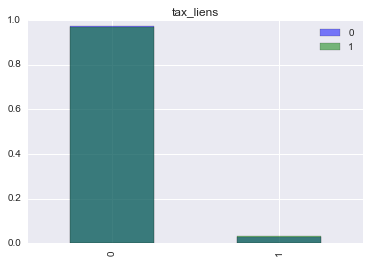

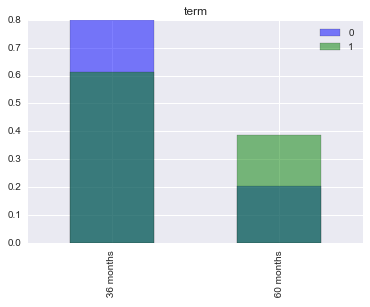

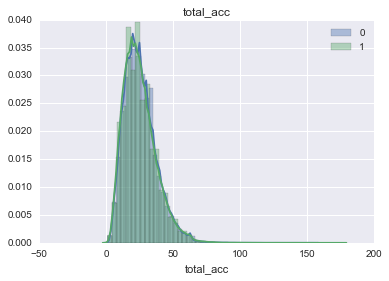

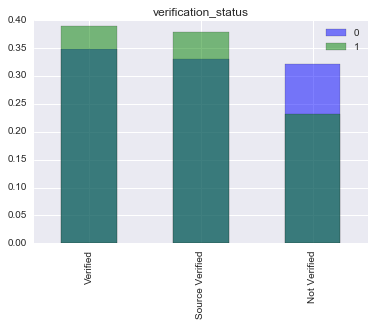

In [18]:
for column in ds.getFeatures()[15:20]:
    plt.figure()
    feature_column = ds.data.loc[:, column].dropna()
    dict_mapping = df_mapping.loc[column, 'comment']
    
    if type(dict_mapping) == float:        
        style = 'continuous'
    else:
        dict_mapping = eval(dict_mapping)
        dict_mapping = {v: k for k, v in dict_mapping.items()}
        feature_column = feature_column.replace(dict_mapping)
        style = 'discrete'
        
    if column in ["fully_funded", "tax_liens"]:
        style = 'discrete'
        
    if style == 'continuous':
        if column in ["annual_inc", "delinq_2yrs", "dti", "pub_rec", "pub_rec_bankruptcies"]:
            feature_column = np.log10(feature_column + 2)
        sns.distplot(feature_column.loc[target_column == 0], label = '0')
        sns.distplot(feature_column.loc[target_column == 1], label = '1')
    else:
        feature_column.loc[target_column == 0].value_counts(normalize = True).plot(kind='bar', 
                                                                               label = '0', 
                                                                               color = 'blue', alpha = .5)
        feature_column.loc[target_column == 1].value_counts(normalize = True).plot(kind='bar', 
                                                                               label = '1', 
                                                                               color = 'green', alpha = .5)
    plt.title(column)
    plt.legend()
    plt.show()

# Prediction

In [40]:
ds_train = ChunkDS(samples=1e5)
ds_train.data = ds_train.data.reset_index()
ds_test = ChunkDS(skip=int(3e5), samples=1e5)

clf = xgb.XGBRegressor()
model = SKlearnWrapper(clf)
objfunc = Accuracy()

In [42]:
model.fit(ds_train)

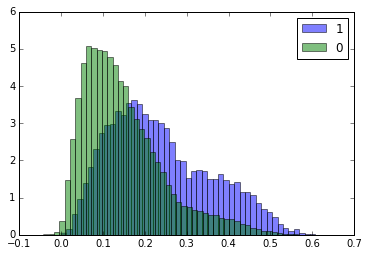

In [51]:
plt.hist(pd.DataFrame(model.predict(ds_train)).loc[ds_train.data.loc[:, ds_train.getLabel()] == 1], 
         bins = 50, label = '1', alpha = .5, normed = True)
plt.hist(pd.DataFrame(model.predict(ds_train)).loc[ds_train.data.loc[:, ds_train.getLabel()] == 0], 
         bins = 50, label = '0', alpha = .5, normed = True)
plt.legend()

In [22]:
np.sqrt(((model.predict(ds_train) - ds_train.data.loc[:, ds_train.getLabel()])**2).mean())

0.35110852009956467

In [15]:
objfunc.evaluate(model, ds_test)

In [16]:
print("Accuracy of this really simple model:")
print("{:.2f}%".format(100 * objfunc.results()))

Accuracy of this really simple model:
0.00%


In [17]:
proportion_non_defaulted = 1 - ds_test.data['status'].sum() / len(ds_test.data['status'])
print("Proportion of non defaulted loans in test set is : {:.2f}%".format(100 * proportion_non_defaulted))

Proportion of non defaulted loans in test set is : 83.27%


## The best setup is to predict constantly not defaulted